# Mental health prediction

Загружаем конфигурацию из config.yaml.

In [2]:
import yaml

with open("D:/projects/spbu-ai-fundamentals/config.yaml", "r") as f:
    cfg = yaml.safe_load(f)

Имортируем нужные библиотеки.

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
import seaborn as sns
from sklearn.preprocessing import RobustScaler, PowerTransformer
from sklearn.preprocessing import FunctionTransformer

Загружаем тренировочные и тестовые данные по пути, указанному в конфиге.

In [4]:
train_df = pd.read_csv(cfg["mental_health"]["train_dataset"])
test_df = pd.read_csv(cfg["mental_health"]["test_dataset"])

### Первая модель

Базовая версия: стандартная предобработка числовых и категориальных признаков.

Использование StandardScaler и OneHotEncoder.

Результаты:

Validation F1: 0.96

Final F1: 0.99457

In [5]:
X = train_df.drop(columns=["Name", "id", "Depression"])
y = train_df["Depression"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42) 

num_features = X.select_dtypes(include=["int64", "float64"]).columns
cat_features = X.select_dtypes(include=["object"]).columns

num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median", keep_empty_features=True)),
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="None", keep_empty_features=True)),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", num_transformer, num_features),
    ("cat", cat_transformer, cat_features)
])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selector', SelectFromModel(LassoCV(cv=5, random_state=42))),
    ('classifier', LogisticRegression())
])

# Метрика качества
model.fit(X_train, y_train)
val_pred = model.predict(X_val)
f1 = f1_score(y_val, val_pred)
print(f'Validation F1-score: {f1:.2f}')

model.fit(X, y)
test_pred = model.predict(test_df.drop(columns=["id"])) 

# Сохранение в csv
submission = pd.DataFrame({"id": test_df["id"], "Depression": test_pred})
submission.to_csv(cfg["mental_health"]["results"], index=False)


Validation F1-score: 0.96


### Вторая модель

Добавлен признак Is_Student.

Пропуски в Academic Pressure, Work Pressure и других заполнены значением -1.

Результаты:

Validation F1: 0.97744

Final F1: 0.99457

In [ ]:
X = train_df.drop(columns=["Name", "id", "Depression"])
y = train_df["Depression"]
X['Is_Student'] = (X['Working Professional or Student'] == 'Student').astype(int)
X = X.drop(columns=["Working Professional or Student"])
X['Academic Pressure'] = X['Academic Pressure'].fillna(-1)
X['Work Pressure'] = X['Work Pressure'].fillna(-1)
X['CGPA'] = X['CGPA'].fillna(-1)
X['Study Satisfaction'] = X['Study Satisfaction'].fillna(-1)
X['Job Satisfaction'] = X['Job Satisfaction'].fillna(-1)

# Для тестовых данных
test_X = test_df.drop(columns=["Name", "id"])
test_X['Is_Student'] = (test_X['Working Professional or Student'] == 'Student').astype(int)  
test_X = test_X.drop(columns=["Working Professional or Student"])
test_X['Academic Pressure'] = test_X['Academic Pressure'].fillna(-1)
test_X['Work Pressure'] = test_X['Work Pressure'].fillna(-1)
test_X['CGPA'] = test_X['CGPA'].fillna(-1)
test_X['Study Satisfaction'] = test_X['Study Satisfaction'].fillna(-1)
test_X['Job Satisfaction'] = test_X['Job Satisfaction'].fillna(-1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42) 

num_features = X.select_dtypes(include=["int64", "float64"]).columns
cat_features = X.select_dtypes(include=["object"]).columns

num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median", keep_empty_features=True)),
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="None", keep_empty_features=True)),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", num_transformer, num_features),
    ("cat", cat_transformer, cat_features)
])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selector', SelectFromModel(LassoCV(cv=5, random_state=42))),
    ('classifier', LogisticRegression())
])

# print(X.head())

# Метрика качества
model.fit(X_train, y_train)
val_pred = model.predict(X_val)
f1 = f1_score(y_val, val_pred)
print(f'Validation F1-score: {f1:.5f}')

model.fit(X, y)
test_pred = model.predict(test_X) 

# Сохранение в csv
submission = pd.DataFrame({"id": test_df["id"], "Depression": test_pred})
submission.to_csv(cfg["mental_health"]["results"], index=False)


selected_mask = model.named_steps['feature_selector'].get_support()
all_feature_names = model.named_steps['preprocessor'].get_feature_names_out()
selected_feature_names = all_feature_names[selected_mask]
coefs = model.named_steps['classifier'].coef_[0]
feature_importance = pd.DataFrame({
    'Feature': selected_feature_names,
    'Importance': np.abs(coefs)
}).sort_values('Importance', ascending=False)

# print(feature_importance)

# 0.97744

Validation F1-score: 0.97744


### Третья модель

Удалены SimpleImputer для обоих признаков.

Упрощён пайплайн предобработки.

Результаты:

Validation F1: 0.97744

Final F1: 0.99457

In [7]:
X = train_df.drop(columns=["Name", "id", "Depression"])
y = train_df["Depression"]
X['Is_Student'] = (X['Working Professional or Student'] == 'Student').astype(int)
X = X.drop(columns=["Working Professional or Student"])
X['Academic Pressure'] = X['Academic Pressure'].fillna(-1)
X['Work Pressure'] = X['Work Pressure'].fillna(-1)
X['CGPA'] = X['CGPA'].fillna(-1)
X['Study Satisfaction'] = X['Study Satisfaction'].fillna(-1)
X['Job Satisfaction'] = X['Job Satisfaction'].fillna(-1)

# Для тестовых данных
test_X = test_df.drop(columns=["Name", "id"])
test_X['Is_Student'] = (test_X['Working Professional or Student'] == 'Student').astype(int)  
test_X = test_X.drop(columns=["Working Professional or Student"])
test_X['Academic Pressure'] = test_X['Academic Pressure'].fillna(-1)
test_X['Work Pressure'] = test_X['Work Pressure'].fillna(-1)
test_X['CGPA'] = test_X['CGPA'].fillna(-1)
test_X['Study Satisfaction'] = test_X['Study Satisfaction'].fillna(-1)
test_X['Job Satisfaction'] = test_X['Job Satisfaction'].fillna(-1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42) 

num_features = X.select_dtypes(include=["int64", "float64"]).columns
cat_features = X.select_dtypes(include=["object"]).columns

num_transformer = Pipeline([
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", num_transformer, num_features),
    ("cat", cat_transformer, cat_features)
])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selector', SelectFromModel(LassoCV(cv=5, random_state=42))),
    ('classifier', LogisticRegression())
])

# print(X.head())

# Метрика качества
model.fit(X_train, y_train)
val_pred = model.predict(X_val)
f1 = f1_score(y_val, val_pred)
print(f'Validation F1-score: {f1:.5f}')

model.fit(X, y)
test_pred = model.predict(test_X) 

# Сохранение в csv
submission = pd.DataFrame({"id": test_df["id"], "Depression": test_pred})
submission.to_csv(cfg["mental_health"]["results"], index=False)

selected_mask = model.named_steps['feature_selector'].get_support()
all_feature_names = model.named_steps['preprocessor'].get_feature_names_out()
selected_feature_names = all_feature_names[selected_mask]
coefs = model.named_steps['classifier'].coef_[0]
feature_importance = pd.DataFrame({
    'Feature': selected_feature_names,
    'Importance': np.abs(coefs)
}).sort_values('Importance', ascending=False)

# print(feature_importance)

# 0.97744

Validation F1-score: 0.97744


### Четвёртая модель

Комбинирование Academic Pressure и Work Pressure в Academic/Work Pressure, а также Study Satisfaction и Job Satisfaction в Study/Job Satisfaction.

Результаты:

Validation F1: 0.97059

Final F1: 1.00000

In [27]:
X = train_df.drop(columns=["Name", "id", "Depression"])
y = train_df["Depression"]
X['Is_Student'] = (X['Working Professional or Student'] == 'Student').astype(int)
X['CGPA'] = X['CGPA'].fillna(-1)
X['Academic/Work Pressure'] = X['Academic Pressure'].where(
    X['Is_Student'] == 1,
    X['Work Pressure']
)
X['Study/Job Satisfaction'] = X['Study Satisfaction'].where(
    X['Is_Student'] == 1,
    X['Job Satisfaction']
)

X = X.drop(columns=["Working Professional or Student", 'Academic Pressure', 'Work Pressure', 'Study Satisfaction', 'Job Satisfaction'])

# Для тестовых данных
test_X = test_df.drop(columns=["Name", "id"])
test_X['Is_Student'] = (test_X['Working Professional or Student'] == 'Student').astype(int)
test_X['CGPA'] = test_X['CGPA'].fillna(-1)
test_X['Academic/Work Pressure'] = test_X['Academic Pressure'].where(
    test_X['Is_Student'] == 1,
    test_X['Work Pressure']
)
test_X['Study/Job Satisfaction'] = test_X['Study Satisfaction'].where(
    test_X['Is_Student'] == 1,
    test_X['Job Satisfaction']
)

test_X = test_X.drop(columns=["Working Professional or Student", 'Academic Pressure', 'Work Pressure', 'Study Satisfaction', 'Job Satisfaction'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42) 

num_features = X.select_dtypes(include=["int64", "float64"]).columns
cat_features = X.select_dtypes(include=["object"]).columns

num_transformer = Pipeline([
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", num_transformer, num_features),
    ("cat", cat_transformer, cat_features)
])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selector', SelectFromModel(LassoCV(cv=5, random_state=42))),
    ('classifier', LogisticRegression())
])

# print(X.head())

# Метрика качества
model.fit(X_train, y_train)
val_pred = model.predict(X_val)
f1 = f1_score(y_val, val_pred)
print(f'Validation F1-score: {f1:.5f}')

model.fit(X, y)
test_pred = model.predict(test_X) 

# Сохранение в csv
submission = pd.DataFrame({"id": test_df["id"], "Depression": test_pred})
submission.to_csv(cfg["mental_health"]["results"], index=False)

selected_mask = model.named_steps['feature_selector'].get_support()
all_feature_names = model.named_steps['preprocessor'].get_feature_names_out()
selected_feature_names = all_feature_names[selected_mask]
coefs = model.named_steps['classifier'].coef_[0]
feature_importance = pd.DataFrame({
    'Feature': selected_feature_names,
    'Importance': np.abs(coefs)
}).sort_values('Importance', ascending=False)

# print(feature_importance)

# 0.97059


Validation F1-score: 0.97059


### Пятая модель

Удаление избыточных столбцов: City, Degree.

Результаты:

Validation F1: 0.97810

Final F1: 1.00000

In [ ]:
X = train_df.drop(columns=["Name", "id", "Depression"])
y = train_df["Depression"]
X['Is_Student'] = (X['Working Professional or Student'] == 'Student').astype(int)
X['CGPA'] = X['CGPA'].fillna(-1)
X['Academic/Work Pressure'] = X['Academic Pressure'].where(
    X['Is_Student'] == 1,
    X['Work Pressure']
)
X['Study/Job Satisfaction'] = X['Study Satisfaction'].where(
    X['Is_Student'] == 1,
    X['Job Satisfaction']
)

X = X.drop(columns=["Working Professional or Student", 'Academic Pressure', 'Work Pressure', 'Study Satisfaction', 'Job Satisfaction', 'City', 'Degree'])

# Для тестовых данных
test_X = test_df.drop(columns=["Name", "id"])
test_X['Is_Student'] = (test_X['Working Professional or Student'] == 'Student').astype(int)
test_X['CGPA'] = test_X['CGPA'].fillna(-1)
test_X['Academic/Work Pressure'] = test_X['Academic Pressure'].where(
    test_X['Is_Student'] == 1,
    test_X['Work Pressure']
)
test_X['Study/Job Satisfaction'] = test_X['Study Satisfaction'].where(
    test_X['Is_Student'] == 1,
    test_X['Job Satisfaction']
)

test_X = test_X.drop(columns=["Working Professional or Student", 'Academic Pressure', 'Work Pressure', 'Study Satisfaction', 'Job Satisfaction', 'City', 'Degree'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42) 

num_features = X.select_dtypes(include=["int64", "float64"]).columns
cat_features = X.select_dtypes(include=["object"]).columns

num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median", keep_empty_features=True)),
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="None", keep_empty_features=True)),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", num_transformer, num_features),
    ("cat", cat_transformer, cat_features)
])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selector', SelectFromModel(LassoCV(cv=5, random_state=42))),
    ('classifier', LogisticRegression())
])

# print(X.head())

# Метрика качества
model.fit(X_train, y_train)
val_pred = model.predict(X_val)
f1 = f1_score(y_val, val_pred)
print(f'Validation F1-score: {f1:.5f}')

model.fit(X, y)
test_pred = model.predict(test_X) 

# Сохранение в csv
submission = pd.DataFrame({"id": test_df["id"], "Depression": test_pred})
submission.to_csv(cfg["mental_health"]["results"], index=False)

# selected_mask = model.named_steps['feature_selector'].get_support()
# all_feature_names = model.named_steps['preprocessor'].get_feature_names_out()
# selected_feature_names = all_feature_names[selected_mask]
# coefs = model.named_steps['classifier'].coef_[0]
# feature_importance = pd.DataFrame({
#     'Feature': selected_feature_names,
#     'Importance': np.abs(coefs)
# }).sort_values('Importance', ascending=False)

# print(feature_importance)

# 0.97810

Validation F1-score: 0.97810


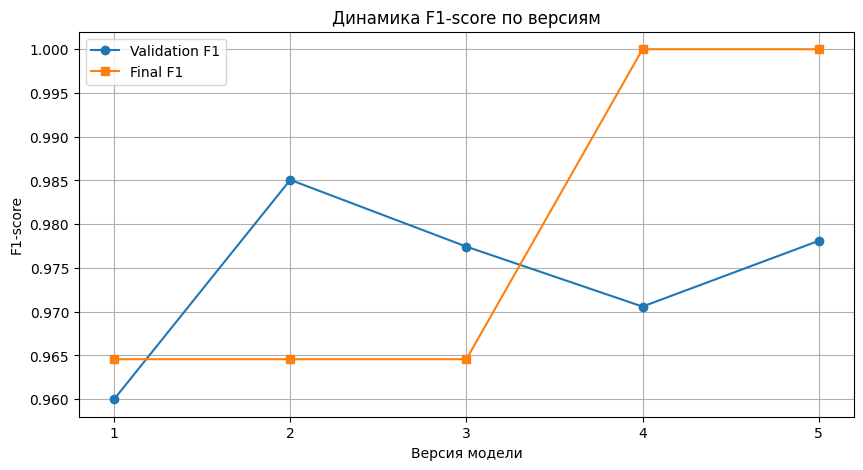

In [26]:
import matplotlib.pyplot as plt

versions = ['1', '2', '3', '4', '5']
val_scores = [0.96, 0.98507, 0.97744, 0.97059, 0.97810]
test_scores = [0.96457, 0.96457, 0.96457, 1.00000, 1.00000]

plt.figure(figsize=(10, 5))
plt.plot(versions, val_scores, marker='o', label='Validation F1')
plt.plot(versions, test_scores, marker='s', label='Final F1')
plt.xlabel('Версия модели')
plt.ylabel('F1-score')
plt.title('Динамика F1-score по версиям')
plt.legend()
plt.grid(True)
plt.show()